In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aapl-data/AAPL1y.csv


In [86]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [87]:
aapl = pd.read_csv("/kaggle/input/aapl-data/AAPL1y.csv")

In [88]:
aapl['Close'] = aapl['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
aapl['Date'] = pd.to_datetime(aapl['Date'])
aapl = aapl.drop(columns=['Volume','Open','High','Low','Close/Last'])

In [89]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    250 non-null    datetime64[ns]
 1   Close   250 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [90]:
def plot_stock(stocks, x='Date', y='Close', xlabel='Date', ylabel='Close Prices USD ($)', title=None):
    plt.figure(figsize=(16,6))
    if title:
        plt.title(title)
    sns.lineplot(x=stocks[x], y=stocks[y], data=stocks)
    plt.xticks(rotation=45)
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


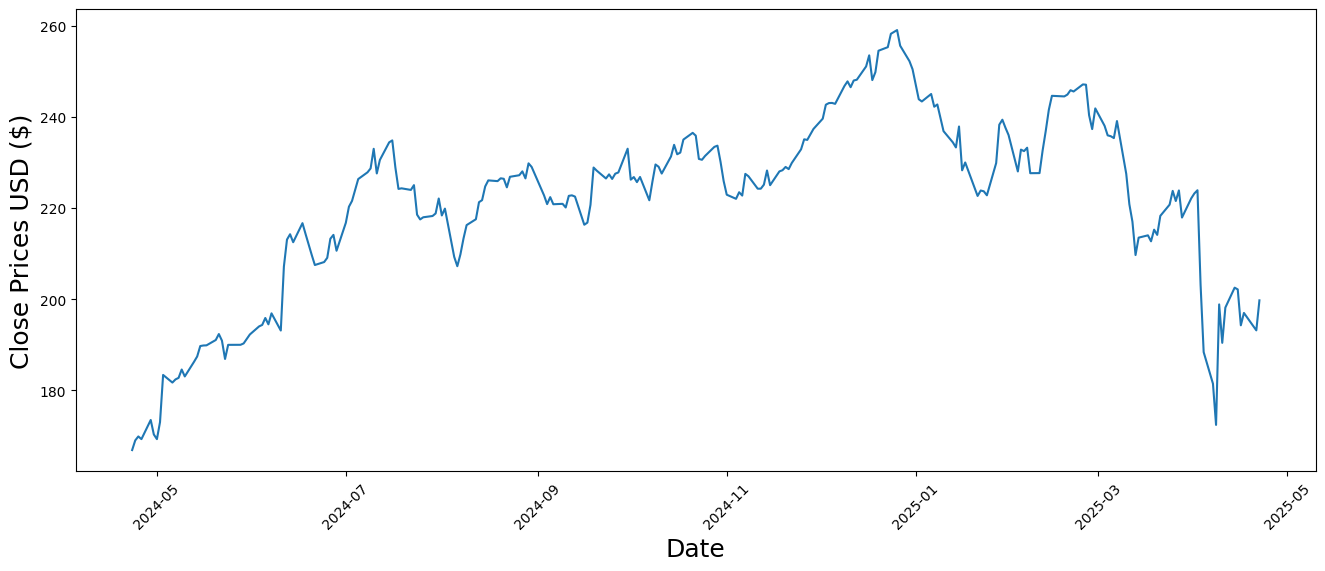

In [91]:
plot_stock(aapl)

In [92]:
def past_data(df, past, column='Close'):
    for i in range(1,past+1):
        df[column+str(i)] = df[column].shift(i)

In [93]:
past_data(aapl, 7)

In [94]:
aapl

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7
0,2025-04-22,199.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-04-21,193.16,199.74,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-04-17,196.98,193.16,199.74,NaN,NaN,NaN,NaN,NaN
3,2025-04-16,194.27,196.98,193.16,199.74,NaN,NaN,NaN,NaN
4,2025-04-15,202.14,194.27,196.98,193.16,199.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
245,2024-04-29,173.50,170.33,169.30,173.03,183.38,181.71,182.40,182.74
246,2024-04-26,169.30,173.50,170.33,169.30,173.03,183.38,181.71,182.40
247,2024-04-25,169.89,169.30,173.50,170.33,169.30,173.03,183.38,181.71
248,2024-04-24,169.02,169.89,169.30,173.50,170.33,169.30,173.03,183.38


In [120]:
def normalize(table,columns):
    scaler = MinMaxScaler()
    
    for column in columns:
        table[column] = scaler.fit_transform(table[column].values.reshape(-1,1))


In [125]:
normalize(aapl, aapl.drop(columns=['Date']).columns)

In [126]:
y = aapl.dropna()['Close']
x = aapl.drop(columns=['Close','Date']).dropna()
idx = aapl['Date']

In [127]:
x

,Close1,Close2,Close3,Close4,Close5,Close6,Close7
7,0.323667,0.370263,0.366028,0.278310,0.308515,0.265938,0.315473
8,0.237778,0.321556,0.370263,0.366028,0.278310,0.308515,0.239492
9,0.331444,0.235399,0.321556,0.370263,0.366028,0.278310,0.283603
10,0.037778,0.329358,0.235399,0.321556,0.370263,0.366028,0.252309
11,0.138222,0.034775,0.329358,0.235399,0.321556,0.370263,0.343187
...,...,...,...,...,...,...,...
245,0.014556,0.000000,0.041574,0.156933,0.138319,0.146010,0.119169
246,0.049778,0.011480,0.000000,0.041574,0.156933,0.138319,0.115242
247,0.003111,0.046812,0.011480,0.000000,0.041574,0.156933,0.107275
248,0.009667,0.000000,0.046812,0.011480,0.000000,0.041574,0.126559


In [128]:
y

7      0.255319
8      0.346830
9      0.059922
10     0.158055
11     0.233174
         ...   
245    0.071646
246    0.026053
247    0.032458
248    0.023013
249    0.000000
Name: Close, Length: 243, dtype: float64

In [129]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(7, 1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 7, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
history = model.fit(x, y, epochs= 50)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3452
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0917
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0235
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0123
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0096
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0087
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0092
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0083
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0064
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0067
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0060
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051
Epoch 15/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056
Epoch 16/50
8/8 ━━━━━━━━━━━━━━━━━━

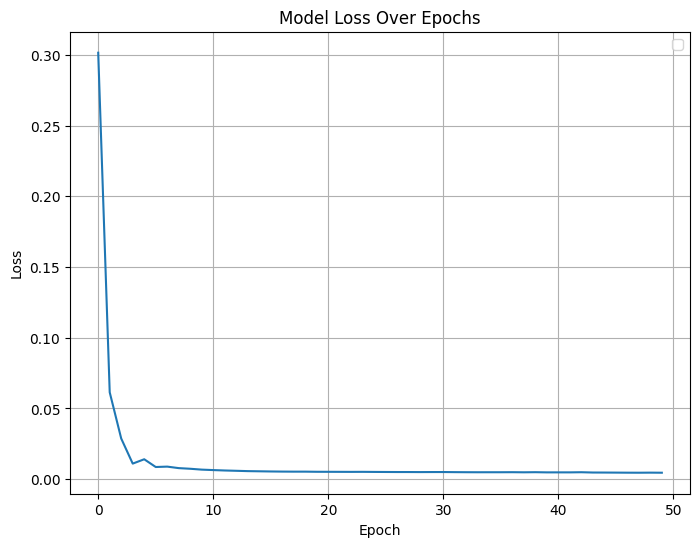

In [131]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


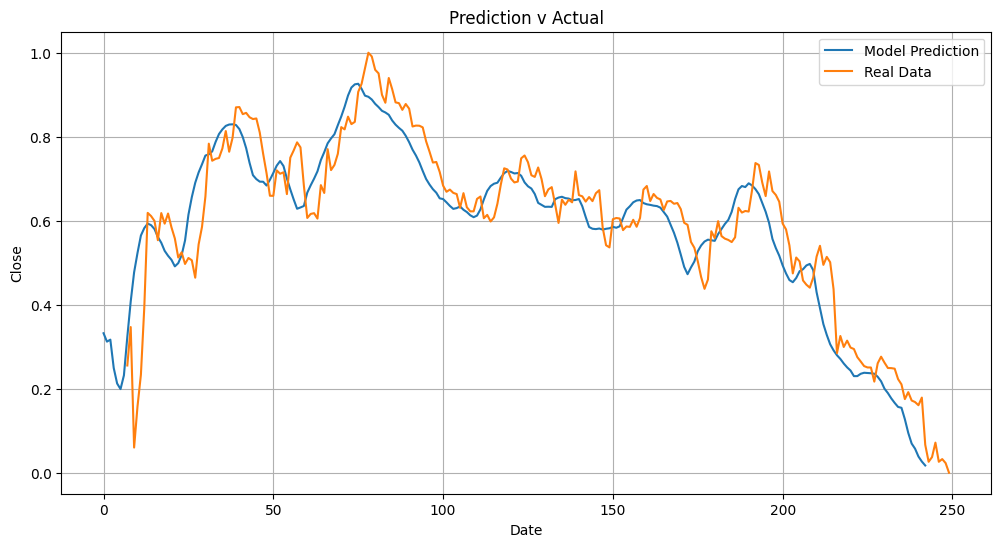

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(model.predict(x), label='Model Prediction')
plt.plot(y, label='Real Data')
plt.title('Prediction v Actual')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()